# **NBA Career Prediction**
**Predict 5-Year Career Longevity for NBA Rookies**

## WEEK 2 - Grid Search Modeling and Hyperopt Boosting XG Boost

In this project, we are trying to classify a rookie player will last at least 5 years in the NBA or not. In this notwbook, we will use search to turn models.
Model includes LRs, XGboost, KNN and Ramdom Forest.

**The steps are:**
1. Read Data
    * Import Libraries
    * Load data
2. Data Exploration 
3. Data visualization
3. Prepare data

## 1. Grid Search Modeling

##### **[1.1]** Import all modules needed

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression as LR
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings(action="ignore")

##### **[1.2]** Import datasets

In [2]:
X_train = np.load('../data/processed/X_train.npy')
y_train = np.load('../data/processed/y_train.npy')

X_ros = np.load('../data/processed/X_ros.npy')
y_ros = np.load('../data/processed/y_ros.npy')

X_sos = np.load('../data/processed/X_sos.npy')
y_sos = np.load('../data/processed/y_sos.npy')

X_kos = np.load('../data/processed/X_kos.npy')
y_kos = np.load('../data/processed/y_kos.npy')

X_val   = np.load('../data/processed/X_val.npy')
y_val  = np.load('../data/processed/y_val.npy')

X_test  = np.load('../data/processed/X_test.npy')

##### **[1.3]** Define functions

In [3]:
# Models dictionary
models = {"Logistic Regression": LR(),
         "KNN": KNeighborsClassifier(),
         "Random Forest": RandomForestClassifier(),
         "XGBoost": XGBClassifier()}

#Function that will evaluate the model performance using various metrics
def evaluate_pred(y_pred, y_val):
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    metric_dict = {"accuracy": round(accuracy, 2), "precision": round(precision, 2), "recall": round(recall, 2),
                  "f1": round(f1,2)}
    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 score: {f1:.2f}")
    
    return metric_dict

# Function that will fit and score the models
def fit_and_score(models, X_train, X_val, y_train, y_val):
    np.random.seed(42)
    
    #Dictionary of model scores
    model_scores = {}
    
    #Loop through models
    for name, model in models.items():
        clf = model
        clf.fit(X_train, y_train)
        model_scores[name] = model.score(X_val, y_val)
    return model_scores

##### **[1.4]** Get default model scores

In [4]:
model_scores = fit_and_score(models, X_train, X_val, y_train, y_val)
model_scores

[22:16:10] WARNING: /private/var/folders/hs/ln67s53n0gxf57pyz_ftzkrw0000gn/T/pip-install-n7uylk98/xgboost_c778489d0ba746e7a2e74a37a7f0c4df/build/temp.macosx-10.9-universal2-3.10/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'Logistic Regression': 0.83875,
 'KNN': 0.81,
 'Random Forest': 0.834375,
 'XGBoost': 0.816875}

##### **[1.5]** Define grid search functions

In [5]:
def grid_search_LR_default():
    # Create hyperparameter options, classweight default
    grid={"C":np.logspace(-4, 4, 20), "penalty":["l1","l2"]}

    # Apply grid search
    log_clf = GridSearchCV(LR(max_iter=10000), grid, cv=5, verbose=0, scoring="roc_auc")

    #Fit
    log_clf.fit(X_train, y_train)

    #instantiate the best estimator
    estimator = log_clf.best_estimator_
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_val)
    y_preds_probs=estimator.predict_proba(X_val)[:,1]
    print(estimator)
    print(f'accuracy:{accuracy_score(y_pred, y_val)}')
    print(f'auc:{roc_auc_score(y_val, y_preds_probs)}')


In [6]:
def grid_search_LR_balanced():
    # Create hyperparameter options, classweight = "balabnced"
    grid={"C":np.logspace(-4, 4, 20), "penalty":["l1","l2"]}

    # Apply grid search
    log_clf = GridSearchCV(LR(max_iter=10000, class_weight='balanced'), grid, cv=5, verbose=0, scoring="roc_auc")

    #Fit
    log_clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    estimator = log_clf.best_estimator_
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_val)
    y_preds_probs=estimator.predict_proba(X_val)[:,1]
    print(estimator)
    print(f'accuracy:{accuracy_score(y_pred, y_val)}')
    print(f'auc:{roc_auc_score(y_val, y_preds_probs)}')


In [7]:
def grid_search_XGboost():
    #Constructing the grid
    param_test1 = {
     'n_estimators':range(100,300,20),
     'max_depth':range(3,10,2),
     'min_child_weight':range(1,10,2)
    }

    #Apply grid search
    xg_clf = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_test1, cv=5, verbose=0, scoring="roc_auc")
    xg_clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    xg_clf1 = xg_clf.best_estimator_
    xg_clf1.fit(X_train, y_train)
    y_pred = xg_clf1.predict(X_val)
    y_preds_proba = xg_clf1.predict_proba(X_val)[:,1]
    print(xg_clf1)
    print(f'accuracy:{accuracy_score(y_pred, y_val)}')
    print(f'auc:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc:{roc_auc_score(y_val, y_preds_proba)}, %')


In [8]:
def grid_search_KNN():
    #Desired range for k parameter
    k_range = list(range(9, 50))

    #Creating grid
    param_grid = dict(n_neighbors=k_range)

    #Applying GridSearchCV
    knn_clf = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, scoring="roc_auc")
    knn_clf.fit(X_train, y_train)
    
    #instantiate the best estimator
    knn_clf1 = knn_clf.best_estimator_
    knn_clf1.fit(X_train, y_train)
    y_pred = knn_clf1.predict(X_val)
    y_preds_proba = knn_clf1.predict_proba(X_val)[:,1]
    print(knn_clf1)
    print(f'accuracy:{accuracy_score(y_pred, y_val)}')
    print(f'auc:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc:{roc_auc_score(y_val, y_preds_proba)}, %')


In [9]:
def grid_search_RF():
    #Creating the grid
    param_grid = {
        'n_estimators': range(100,300,20),
        'max_depth': range(3,15,2),
        'random_state': [8888],
        #'max_features': ['auto'],
        #'criterion' :['gini']
    }

    #Applying grid search
    cv_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 10, scoring="roc_auc")
    cv_rfc.fit(X_train, y_train)
    
    #instantiate the best estimator
    rfc = cv_rfc.best_estimator_
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_val)
    y_preds_proba = rfc.predict_proba(X_val)[:,1]
    print(rfc)
    print(f'accuracy:{accuracy_score(y_pred, y_val)}')
    print(f'auc:{roc_auc_score(y_val, y_pred)}, 1&0')
    print(f'auc:{roc_auc_score(y_val, y_preds_proba)}, %')


##### **[1.6]** Define start grid search function

In [10]:
def grid_search_start():
    print("LR default:")
    grid_search_LR_default()
    print()
    print("LR balanced:")
    grid_search_LR_balanced()
    print()
    print("XGboost:")
    grid_search_XGboost()
    print()
    print("KNN:")
    grid_search_KNN()
    print()
    print("RF:")
    grid_search_RF()


##### **[1.7]** Get results

In [11]:
print("Data Cleaning: use wk2 result - scaled, negs subs with mode, recalculated %s and corresponding data, delete columns, substitue upper outliers with mode, use historical best records as threshold.")
grid_search_start()

Data Cleaning: use wk2 result - scaled, negs subs with mode, recalculated %s and corresponding data, delete columns, substitue upper outliers with mode, use historical best records as threshold.
LR default:
LogisticRegression(C=0.012742749857031334, max_iter=10000)
accuracy:0.835
auc:0.7061525628163362

LR balanced:
LogisticRegression(C=0.004832930238571752, class_weight='balanced',
                   max_iter=10000)
accuracy:0.653125
auc:0.7053155752950593

XGboost:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              r

## 2. Start Hyperopt boosting XGboost

##### **[2.1]** Import all modules needed

In [12]:
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin

##### **[2.2]** Define search spaces and functions

In [13]:
# Define search spaces
space = {
    'max_depth' : hp.choice('max_depth', range(5, 20, 1)),
    'learning_rate' : hp.quniform('learning_rate', 0.01, 0.5, 0.05),
    'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
    'subsample' : hp.quniform('subsample', 0.1, 1, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1.0, 0.05)
}

In [14]:
# Define objective sunction and self-defined loss function (aimming for higher AUC)
def objective(space):
    from sklearn.model_selection import cross_val_score
    
    xgboost = XGBClassifier(
        max_depth = int(space['max_depth']),
        learning_rate = space['learning_rate'],
        min_child_weight = space['min_child_weight'],
        subsample = space['subsample'],
        colsample_bytree = space['colsample_bytree'],
        eval_metric = 'auc'
    )
    
    auc = cross_val_score(xgboost, X_train, y_train, cv=10, scoring="roc_auc").mean()

    return{'loss': 1-auc, 'status': STATUS_OK }

##### **[2.3]** Get Hyperopted XGBoost model and predict

In [16]:
# Start hyperboosting 
best = fmin(
    fn=objective,   
    space=space,       
    algo=tpe.suggest,       
    max_evals=200 # can use larger value to increase optimization power
)

100%|████████████████████████████████████████████████████████████████████████| 200/200 [15:55<00:00,  4.78s/trial, best loss: 0.30968404708555775]


In [17]:
# Print best model from hyperopt
print("Best: ", best)

Best:  {'colsample_bytree': 0.65, 'learning_rate': 0.05, 'max_depth': 0, 'min_child_weight': 2.0, 'subsample': 0.4}


In [18]:
# Instantiate best estimator from hyperopt
xgboost2 = XGBClassifier(
    max_depth = best['max_depth'],
    learning_rate = best['learning_rate'],
    min_child_weight = best['min_child_weight'],
    subsample = best['subsample'],
    colsample_bytree = best['colsample_bytree'],
    eval_metric = 'auc'
)

# Fit train data
xgboost2.fit(X_train, y_train)

# Predict validation dataset and print accuracy and auc score
y_val_preds = xgboost2.predict(X_val)
y_val_proba = xgboost2.predict_proba(X_val)[:,1]
print(f'accuracy:{accuracy_score(y_val_preds, y_val)}')
print(f'auc:{roc_auc_score(y_val, y_val_preds)}, 1&0')
print(f'auc:{roc_auc_score(y_val, y_val_proba)}, %')

accuracy:0.83375
auc:0.5, 1&0
auc:0.5, %


##### **[2.4]** Compare model scores

**Note:**

Comparing the AUC scores from 4 models using grid search and 1 XGboost model from hyperopt, the best one is default LR, followed by balanced LR then RF.

Select default LR as the wk2 classifier.

We can see the balanced LR model is with a lower accuracy at 0.65, which needs further investigation next week.

Also, the auc for the hyperopted XGboost is suggesting it is overfitted to the train data, which might be resolved next week by reducing the max_evals.

## 3. Best model Prediction

##### **[3.1]** Instantiate best model and predict 

In [20]:
classifier = LR(C=0.012742749857031334, max_iter=10000)
classifier.fit(X_train, y_train)
y_val_preds_probs=classifier.predict_proba(X_val)
y_val_preds = classifier.predict(X_val)

##### **[3.2]** Plot AUC graph

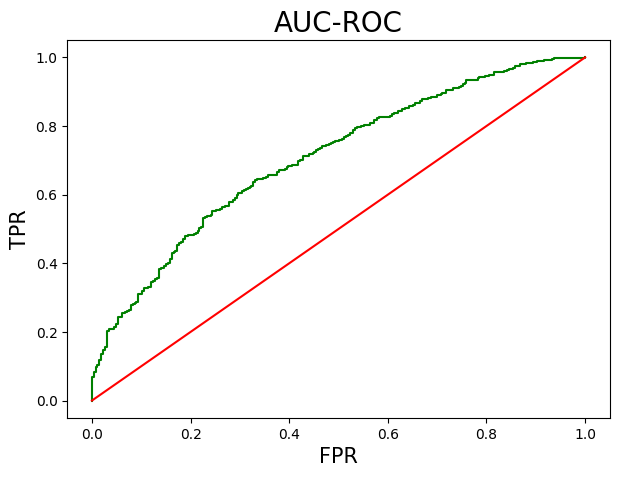

0.7061525628163362

In [21]:
fpr,tpr,threshold=roc_curve(y_val,y_val_preds_probs[:,1])
plt.figure(figsize=(7,5),dpi=100)
plt.plot(fpr,tpr,color='green')
plt.plot([0,1],[0,1],label='baseline',color='red')
plt.xlabel('FPR',fontsize=15)
plt.ylabel('TPR',fontsize=15)
plt.title('AUC-ROC',fontsize=20)
plt.show()
roc_auc_score(y_val,y_val_preds_probs[:,1])

##### **[3.3]** Predict test set and save

In [28]:
X_test = np.load('../data/processed/X_test.npy')
predict = classifier.predict_proba(X_test)[:,1]
test = pd.read_csv('../data/raw/test.csv')
result = pd.DataFrame(data = {'Id': test.loc[:,'Id'], 'TARGET_5Yrs': predict})
result.to_csv("../data/external/wenying_LR_v10.csv", index = False)